In [1]:
%load_ext autoreload
%autoreload 2

### Load the Config File

In [2]:
import yaml
import shutil
import os

# config_path = "checkpoints/smallmodelmediumdisc/config_medium.yaml"
config_path = "config_medium.yaml"


# Load the YAML
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

    os.makedirs(cfg["training"]["checkpoint_dir"], exist_ok=True)
    shutil.copy(config_path, cfg["training"]["checkpoint_dir"])

### Define the DataLoader

In [ ]:
import torch
from torch.utils.data import DataLoader
from src.datasets import FSD50K, collate_fn_audio
from torch.utils.data import Subset

dl_cfg = cfg["dataloader"]
batch_size = dl_cfg["batch_size"]
num_workers = dl_cfg["num_workers"]
nsecs = dl_cfg["nsecs"]
shuffle = dl_cfg["shuffle"]
train_subset_size = dl_cfg["train_subset_size"]
test_subset_size = dl_cfg["test_subset_size"]
dataset_path = dl_cfg["dataset_path"]

train_dataset = FSD50K(dataset_path, split="train")
test_dataset = FSD50K(dataset_path, split="test")

if train_subset_size is None:
    train_subset_size = int(len(train_dataset))

if test_subset_size is None:
    test_subset_size = int(len(test_dataset))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)

train_dl = DataLoader(Subset(train_dataset, range(train_subset_size)), 
                batch_size=batch_size, 
                shuffle=shuffle,
                num_workers=num_workers,
                collate_fn=lambda x: collate_fn_audio(x, nsecs=nsecs))

test_dl = DataLoader(Subset(test_dataset, range(test_subset_size)), 
                batch_size=batch_size, 
                shuffle=shuffle,
                num_workers=num_workers,
                collate_fn=lambda x: collate_fn_audio(x, nsecs=nsecs))

### Define the Model and Discriminators

In [4]:
import yaml
from src.utils import load_model_from_config, load_discriminators_from_config
from encodec.msstftd import MultiScaleSTFTDiscriminator
import torchaudio

from encodec.msstftd import DiscriminatorSTFT
from encodec.modules.conv import NormConv2d
from encodec.msstftd import get_2d_padding
import typing as tp
import torch.nn as nn

def patched_init(self, filters: int, in_channels: int = 1, out_channels: int = 1,
                n_fft: int = 1024, hop_length: int = 256, win_length: int = 1024, max_filters: int = 1024,
                filters_scale: int = 1, kernel_size: tp.Tuple[int, int] = (3, 9), dilations: tp.List = [1, 2, 4],
                stride: tp.Tuple[int, int] = (1, 2), normalized: bool = True, norm: str = 'weight_norm',
                activation: str = 'LeakyReLU', activation_params: dict = {'negative_slope': 0.2}):
    torch.nn.Module.__init__(self)
    assert len(kernel_size) == 2
    assert len(stride) == 2
    self.filters = filters
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.n_fft = n_fft
    self.hop_length = hop_length
    self.win_length = win_length
    self.normalized = normalized
    self.activation = getattr(torch.nn, activation)(**activation_params)
    self.spec_transform = torchaudio.transforms.Spectrogram(
        n_fft=self.n_fft, hop_length=self.hop_length, win_length=self.win_length, window_fn=torch.hann_window,
        normalized=self.normalized, center=False, pad_mode=None, power=None)
    spec_channels = 2 * self.in_channels
    self.convs = nn.ModuleList()
    self.convs.append(
        NormConv2d(spec_channels, self.filters, kernel_size=kernel_size, padding=get_2d_padding(kernel_size))
    )
    in_chs = self.filters
    for i, dilation in enumerate(dilations):
        out_chs = min((filters_scale ** (i + 1)) * self.filters, max_filters)
        self.convs.append(NormConv2d(in_chs, out_chs, kernel_size=kernel_size, stride=stride,
                                        dilation=(dilation, 1), padding=get_2d_padding(kernel_size, (dilation, 1)),
                                        norm=norm))
        in_chs = out_chs
    out_chs = min((filters_scale ** (len(dilations) + 1)) * self.filters, max_filters)
    self.convs.append(NormConv2d(in_chs, out_chs, kernel_size=(kernel_size[0], kernel_size[0]),
                                    padding=get_2d_padding((kernel_size[0], kernel_size[0])),
                                    norm=norm))
    self.conv_post = NormConv2d(out_chs, self.out_channels,
                                kernel_size=(kernel_size[0], kernel_size[0]),
                                padding=get_2d_padding((kernel_size[0], kernel_size[0])),
                                norm=norm)

DiscriminatorSTFT.__init__ = patched_init


model = load_model_from_config(cfg)
discriminators = load_discriminators_from_config(cfg)

model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {model_params:,}")

disc_params = sum(p.numel() for p in discriminators.parameters() if p.requires_grad)
print(f"Discriminators parameters: {disc_params:,}")

print(f"Total parameters: {model_params + disc_params:,}")

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Model parameters: 5,146,624
Discriminators parameters: 377,864
Total parameters: 5,524,488


In [5]:
# model.load_model("checkpoints/smallmodelmediumdisc/model/epoch_48.pth")

In [6]:
torch.autograd.set_detect_anomaly(True)

### Train the Model

In [ ]:
training_cfg = cfg["training"]
num_epochs = training_cfg["num_epochs"]
discriminator_train_freq = training_cfg["discriminator_train_freq"]
d_train_prob = training_cfg["d_train_prob"]
checkpoint_freq = training_cfg["checkpoint_freq"]
eval_freq = training_cfg["eval_freq"]
start_checkpoint = training_cfg["start_checkpoint"]
writer_dir = training_cfg["writer_dir"]
checkpoint_dir = training_cfg["checkpoint_dir"]
checkpoint_dir = training_cfg["checkpoint_dir"]
lr_generator = training_cfg["lr_generator"]
lr_discriminator = training_cfg["lr_discriminator"]
weight_decay = training_cfg["weight_decay"]
betas = training_cfg["betas"]
lambdas = training_cfg["lambdas"]

model.train_model(train_dl=train_dl,
                    test_dl=test_dl,
                    discriminators=discriminators,
                    num_epochs=num_epochs,
                    discriminator_train_freq=discriminator_train_freq,
                    d_train_prob=d_train_prob,
                    checkpoint_freq=checkpoint_freq,
                    start_checkpoint=start_checkpoint,
                    eval_freq=eval_freq,
                    writer_dir=writer_dir,
                    checkpoint_dir=checkpoint_dir,
                    lr_g=lr_generator, 
                    weight_decay=weight_decay,
                    lr_d=lr_discriminator,
                    betas=betas,
                    lambdas=lambdas)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (17) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (33) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank 

Model saved at epoch 0
Epoch 0: Max GPU memory used = 4909.17 MB


Validation progress:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Epoch 1: Max GPU memory used = 4911.35 MB


Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Model saved at epoch 2
Epoch 2: Max GPU memory used = 4912.84 MB


Validation progress:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Epoch 3: Max GPU memory used = 4913.84 MB


Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Model saved at epoch 4
Epoch 4: Max GPU memory used = 4914.51 MB


Validation progress:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Epoch 5: Max GPU memory used = 4906.46 MB


Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

Model saved at epoch 6
Epoch 6: Max GPU memory used = 4912.29 MB


Validation progress:   0%|          | 0/394 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/1576 [00:00<?, ?it/s]

/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (17) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (33) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(
/home/angel/anaconda3/envs/thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank 

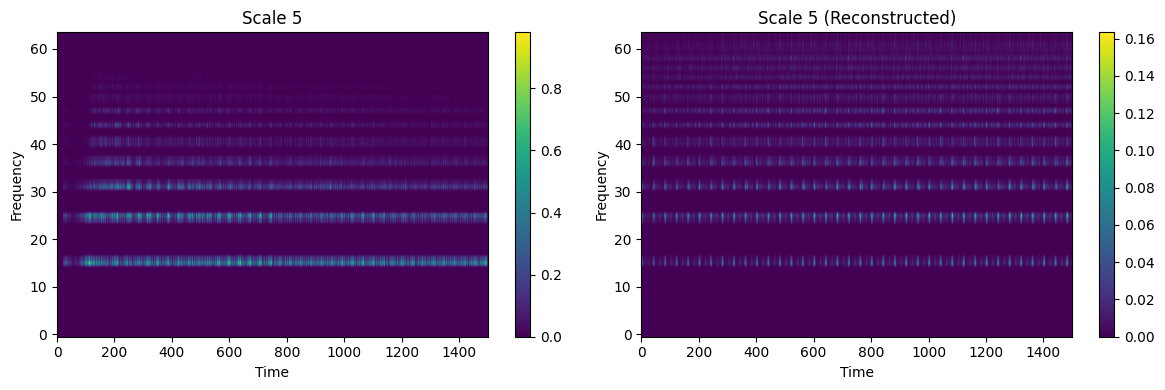

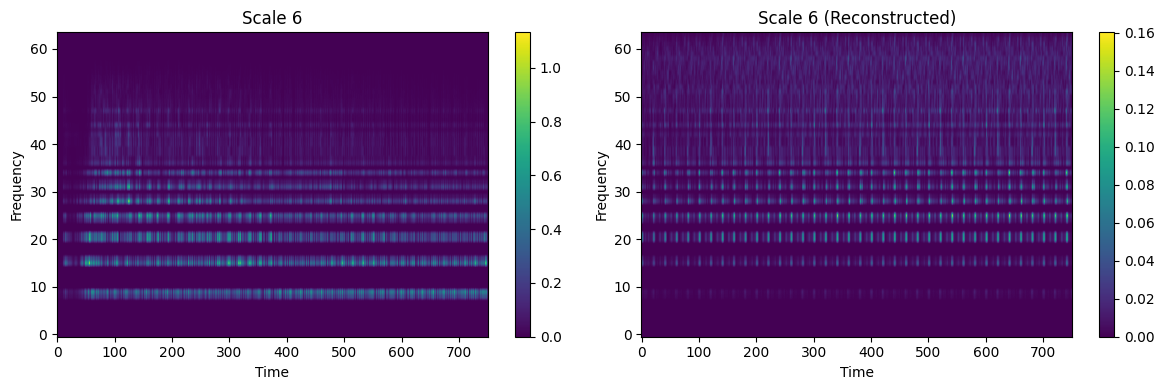

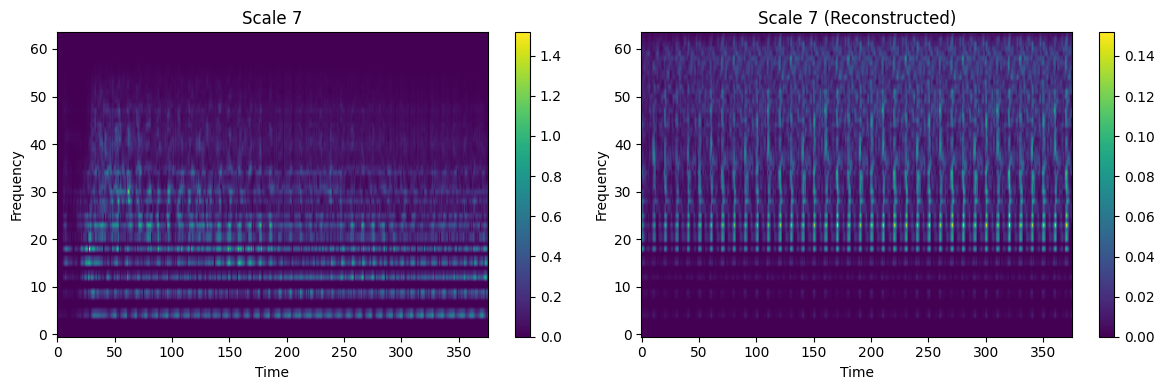

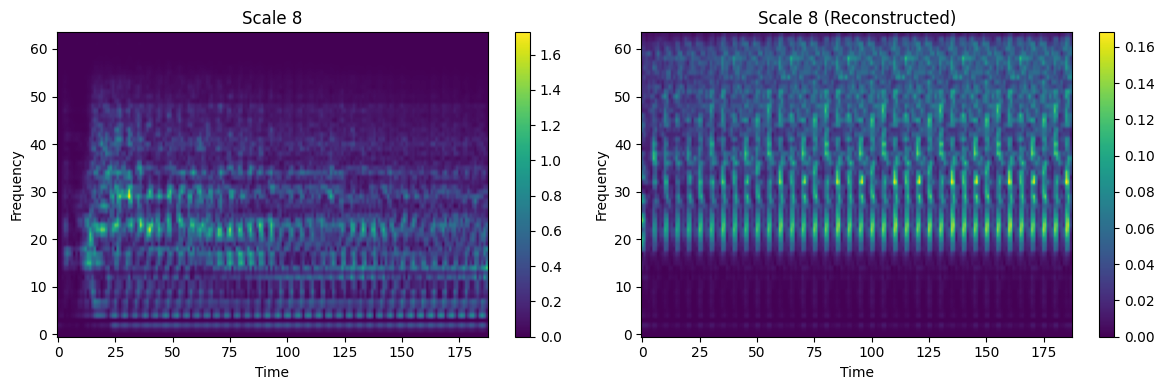

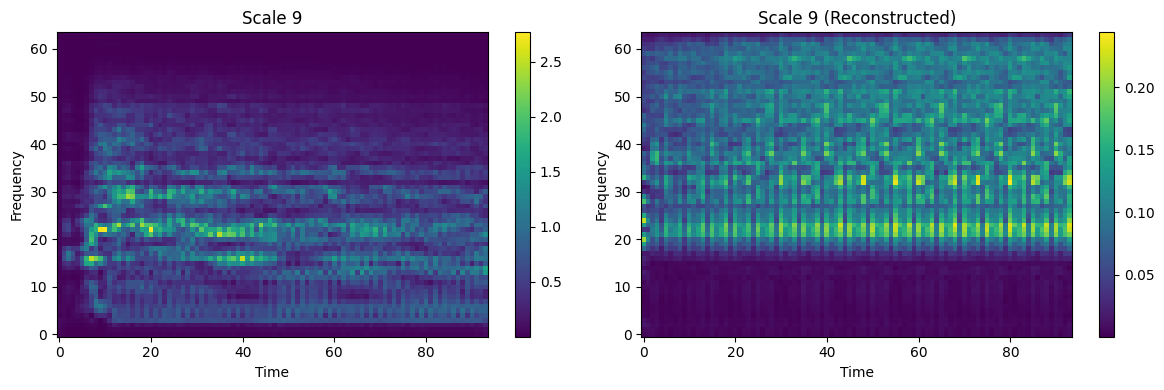

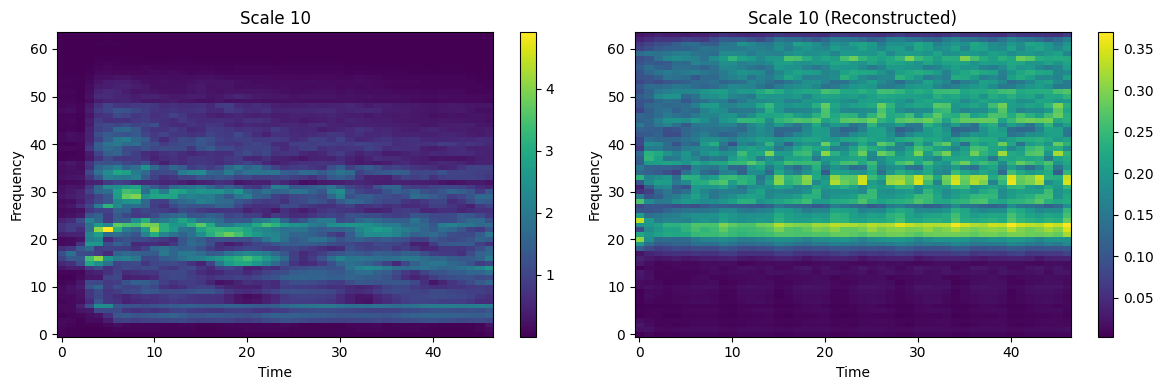

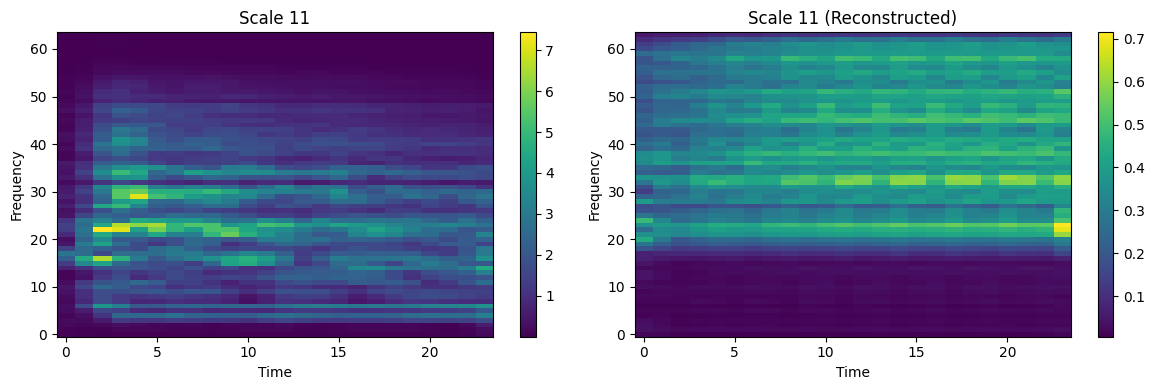

torch.Size([7])


In [ ]:
from src.losses import MultiScaleSpectrogramLoss


class MultiScaleSpectrogram(torch.nn.Module):
    """
    Multiscale frequency-domain loss using torchaudio.transforms.Spectrogram.

    ℓ_f(x, x̂) = (1/|S|) * Σ_{i∈S} [ ||S_i(x) - S_i(x̂)||_1  +  α_i ||S_i(x) - S_i(x̂)||_2 ]
    with S = {5,6,7,8,9,10,11}, win_length=2**i, hop=2**i//4, n_fft=2**i, α_i=1.
    """
    def __init__(self, scales=range(5, 12), power=1.0, eps=1e-8):
        super().__init__()
        self.scales = list(scales)
        self.power = power
        self.eps = eps

        # Build one Spectrogram transform per scale
        self.specs = torch.nn.ModuleDict()
        for i in self.scales:
            n = 2 ** i
            self.specs[str(i)] = torchaudio.transforms.MelSpectrogram(
                n_mels=64,
                sample_rate=24000,
                n_fft=n,
                win_length=n,
                hop_length=n // 4,
                power=self.power,     # 1.0 -> magnitude, 2.0 -> power
                normalized=True,
                center=True,
                pad_mode="reflect"
            )

    def forward(self, x):
        X = []
        for i in self.scales:
            S = self.specs[str(i)]
            X.append(S(x))                      # (B, 1, F, T')

        return X

class FrequencyDomainLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse_loss = torch.nn.MSELoss()

    def forward(self, x, x_hat):
        return self.mse_loss(x, x_hat)

import matplotlib.pyplot as plt
import IPython.display as ipd

model.eval()
discriminators.eval()
for param in model.parameters(): param.requires_grad = False
for param in discriminators.parameters(): param.requires_grad = False

for wavs in train_dl:

    wavs = wavs.to(device)
    
    x_hat = model(wavs)["x_hat"]
    ipd.display(ipd.Audio(wavs[0, :, :].cpu(), rate=24000))
    ipd.display(ipd.Audio(x_hat[0, :, :].detach().cpu().numpy(), rate=24000))

    spec = MultiScaleSpectrogram().to(wavs.device)
    X = spec(wavs)
    X_hat = spec(x_hat)

    # Plot the spectrograms
    for i, (spec, spec_hat) in enumerate(zip(X, X_hat)):
        # Get rid of the batch dimension
        spec = spec.squeeze(1)
        spec_hat = spec_hat.squeeze(1)
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))
        axs[0].imshow(spec[0, :, :].detach().cpu(), aspect='auto', origin='lower')
        axs[0].set_title(f'Scale {i + 5}')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Frequency')
        fig.colorbar(axs[0].images[0], ax=axs[0])
        axs[1].imshow(spec_hat[0, :, :].detach().cpu(), aspect='auto', origin='lower')
        axs[1].set_title(f'Scale {i + 5} (Reconstructed)')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Frequency')
        fig.colorbar(axs[1].images[0], ax=axs[1])
        plt.tight_layout()
        plt.show()

    losses = []
    for real, fake in zip(X, X_hat):
        l1 = torch.abs(real - fake).mean()
        l2 = torch.pow(real - fake, 2).mean()
        loss = l1 + l2
        losses.append(loss)
    

    print(torch.stack(losses).shape)  # (num_scales, B, 1, F, T')
    break

In [ ]:
import torch.nn.functional as F

for wavs in train_dl:

    wavs = wavs.to(device)
    wavs = torch.nan_to_num(wavs, nan=0.0, posinf=0.0, neginf=0.0)

    res = model(wavs)
    
    real_logits, real_fmap = discriminators(wavs)
    fake_logits, fake_fmap = discriminators(res["x_hat"])

    r = real_logits[0]#.mean(dim=(1, 2, 3))
    f = fake_logits[0]#.mean(dim=(1, 2, 3))
    print(r.shape, f.shape)

    d_loss = (F.relu(1 - r).mean() + F.relu(1 + f).mean()).mean()
    g_loss = F.relu(1 - f).mean()

    r = r.mean(dim=(1, 2, 3))
    f = f.mean(dim=(1, 2, 3))
    # r = r.mean(dim=1)
    # f = f.mean(dim=1)
    
    alt_d_loss = F.relu(1 - r).mean() + F.relu(1 + f).mean()
    alt_g_loss = F.relu(1 - f).mean()

    print(real_logits[0].shape, fake_logits[0].shape)
    print(r, f)
    print(d_loss, g_loss)
    print(alt_d_loss, alt_g_loss)
    break

torch.Size([36, 1, 372, 33]) torch.Size([36, 1, 372, 33])
torch.Size([36, 1, 372, 33]) torch.Size([36, 1, 372, 33])
tensor([17.6692, 12.1484, 15.6583,  8.9343,  2.6234, 18.7982,  8.6429, 13.3232,
         5.7235,  2.3935, 15.0768, 13.6479,  7.1685, 10.5153,  6.6549,  7.1124,
        27.7699,  3.5213, 12.5637, 41.3459, 13.1170,  4.7051, 25.0323,  2.2664,
        24.6342, 14.2754,  5.9874, 22.5566, 15.8793,  2.9058,  6.6028,  6.1457,
        10.2536, 16.0878,  5.4576,  1.8810], device='cuda:0') tensor([-1.0337, -1.0338, -1.0337, -1.0338, -1.0338, -1.0337, -1.0338, -1.0338,
        -1.0338, -1.0338, -1.0337, -1.0337, -1.0338, -1.0337, -1.0338, -1.0338,
        -1.0339, -1.0337, -1.0339, -1.0338, -1.0339, -1.0339, -1.0339, -1.0337,
        -1.0338, -1.0337, -1.0338, -1.0338, -1.0337, -1.0338, -1.0338, -1.0338,
        -1.0338, -1.0338, -1.0339, -1.0338], device='cuda:0')
tensor([[[[0.6506, 0.3834, 0.1534,  ..., 1.5576, 1.7041, 1.8566],
          [0.5145, 0.1282, 0.0000,  ..., 1.4638, 1.493

In [ ]:
real_fmap[1][1].shape

torch.Size([36, 16, 184, 65])

In [ ]:
import numpy as np
losses = 0.0
for r_fmap, f_fmap in zip(real_fmap, fake_fmap):
    layer_losses = 0.0
    for r_layer, f_layer in zip(r_fmap, f_fmap):
        
        # Layer dims: [B, filters, T, F]
        # r_layer = r_layer.mean(dim=(1, 2, 3)) # r: 
        # f_layer = f_layer.mean(dim=(1, 2, 3))

        num = r_layer.abs() - f_layer.abs()
        den = r_layer.abs().mean()
        loss = (num / (den + 1e-8)).mean()
        layer_losses = layer_losses + loss
    perD_loss = layer_losses / len(r_fmap)
    print(f"Layer losses: {layer_losses}")
    print(f"perD loss: {perD_loss}")
    losses = losses + perD_loss
feat_loss = losses / len(real_fmap)
print(f"Feature loss: {feat_loss}")


tensor(0.7354, device='cuda:0')
tensor(0.6950, device='cuda:0')
tensor(0.8540, device='cuda:0')
Layer losses: 2.2844583988189697
perD loss: 0.7614861726760864
tensor(0.6099, device='cuda:0')
tensor(0.8498, device='cuda:0')
tensor(0.9130, device='cuda:0')
Layer losses: 2.37271785736084
perD loss: 0.7909059524536133
tensor(0.6296, device='cuda:0')
tensor(0.8359, device='cuda:0')
tensor(0.8861, device='cuda:0')
Layer losses: 2.351632833480835
perD loss: 0.7838776111602783
tensor(0.6077, device='cuda:0')
tensor(0.6780, device='cuda:0')
tensor(0.8537, device='cuda:0')
Layer losses: 2.1393916606903076
perD loss: 0.7131305932998657
tensor(0.5976, device='cuda:0')
tensor(0.7468, device='cuda:0')
tensor(0.8073, device='cuda:0')
Layer losses: 2.151803970336914
perD loss: 0.7172679901123047
Feature loss: 0.7533336877822876


In [ ]:
F.relu(1 + f)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')